In [1]:
from gtsam import *


Factor Graph:
NonlinearFactorGraph: size: 6

Factor 0: PriorFactor on 1
  prior mean:  (0, 0, 0)
  noise model: diagonal sigmas [0.3; 0.3; 0.1];

Factor 1: BetweenFactor(1,2)
  measured:  (2, 0, 0)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 2: BetweenFactor(2,3)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 3: BetweenFactor(3,4)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 4: BetweenFactor(4,5)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 5: BetweenFactor(5,2)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];



Initial Estimate:
Values with 5 values:
Value 1: (gtsam::Pose2)
(0.5, 0, 0.2)

Value 2: (gtsam::Pose2)
(2.3, 0.1, -0.2)

Value 3: (gtsam::Pose2)
(4.1, 0.1, 1.57079633)

Value 4: (gtsam::Pose2)
(4, 2, 3.14159265)

Value 5: (gtsam::Pose2)
(2.1, 2.1, -1.57079633)


Final Result:
Values with 5 values:
Value 1: (g

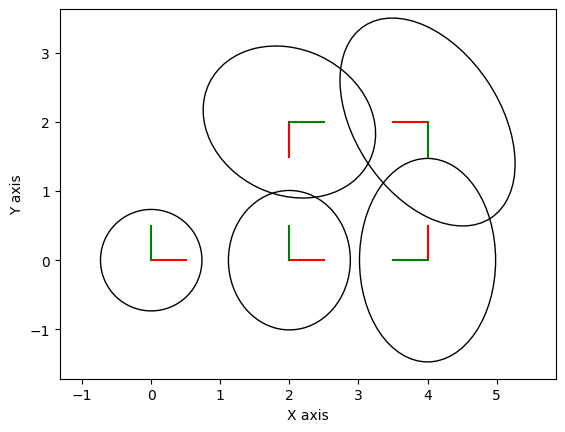

In [3]:

from __future__ import print_function

import math

import gtsam
import gtsam.utils.plot as gtsam_plot
import matplotlib.pyplot as plt



# Create noise models
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(0.3, 0.3, 0.1))
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(
    gtsam.Point3(0.2, 0.2, 0.1))

# 1. Create a factor graph container and add factors to it
graph = gtsam.NonlinearFactorGraph()

# 2a. Add a prior on the first pose, setting it to the origin
# A prior factor consists of a mean and a noise ODOMETRY_NOISE (covariance matrix)
graph.add(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), PRIOR_NOISE))

# 2b. Add odometry factors
# Create odometry (Between) factors between consecutive poses
graph.add(
    gtsam.BetweenFactorPose2(1, 2, gtsam.Pose2(2, 0, 0), ODOMETRY_NOISE))
graph.add(
    gtsam.BetweenFactorPose2(2, 3, gtsam.Pose2(2, 0, math.pi / 2),
                                ODOMETRY_NOISE))
graph.add(
    gtsam.BetweenFactorPose2(3, 4, gtsam.Pose2(2, 0, math.pi / 2),
                                ODOMETRY_NOISE))
graph.add(
    gtsam.BetweenFactorPose2(4, 5, gtsam.Pose2(2, 0, math.pi / 2),
                                ODOMETRY_NOISE))

# 2c. Add the loop closure constraint
# This factor encodes the fact that we have returned to the same pose. In real
# systems, these constraints may be identified in many ways, such as appearance-based
# techniques with camera images. We will use another Between Factor to enforce this constraint:
graph.add(
    gtsam.BetweenFactorPose2(5, 2, gtsam.Pose2(2, 0, math.pi / 2),
                                ODOMETRY_NOISE))
print("\nFactor Graph:\n{}".format(graph))  # print

# 3. Create the data structure to hold the initial_estimate estimate to the
# solution. For illustrative purposes, these have been deliberately set to incorrect values
initial_estimate = gtsam.Values()
initial_estimate.insert(1, gtsam.Pose2(0.5, 0.0, 0.2))
initial_estimate.insert(2, gtsam.Pose2(2.3, 0.1, -0.2))
initial_estimate.insert(3, gtsam.Pose2(4.1, 0.1, math.pi / 2))
initial_estimate.insert(4, gtsam.Pose2(4.0, 2.0, math.pi))
initial_estimate.insert(5, gtsam.Pose2(2.1, 2.1, -math.pi / 2))
print("\nInitial Estimate:\n{}".format(initial_estimate))  # print

# 4. Optimize the initial values using a Gauss-Newton nonlinear optimizer
# The optimizer accepts an optional set of configuration parameters,
# controlling things like convergence criteria, the type of linear
# system solver to use, and the amount of information displayed during
# optimization. We will set a few parameters as a demonstration.
parameters = gtsam.GaussNewtonParams()

# Stop iterating once the change in error between steps is less than this value
parameters.setRelativeErrorTol(1e-5)
# Do not perform more than N iteration steps
parameters.setMaxIterations(100)
# Create the optimizer ...
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, parameters)
# ... and optimize
result = optimizer.optimize()
print("Final Result:\n{}".format(result))

# 5. Calculate and print marginal covariances for all variables
marginals = gtsam.Marginals(graph, result)
for i in range(1, 6):
    print("X{} covariance:\n{}\n".format(i,
                                            marginals.marginalCovariance(i)))

for i in range(1, 6):
    gtsam_plot.plot_pose2(0, result.atPose2(i), 0.5,
                            marginals.marginalCovariance(i))

plt.axis('equal')
plt.show()
